# 🎬 Movie Recommendation System using SVD

## Welcome! 👋

In this notebook, we'll build a **Movie Recommendation System** using **SVD (Singular Value Decomposition)**.

### What You'll Learn:
- ✅ How to load and explore movie rating data
- ✅ What a User-Item Matrix is
- ✅ How SVD works for recommendations
- ✅ How to predict movie ratings
- ✅ How to recommend movies to users

Let's get started! 🚀

---
## 📦 Step 1: Import Required Libraries

We need:
- **pandas** - for data manipulation
- **numpy** - for numerical operations
- **matplotlib & seaborn** - for visualizations
- **scipy** - for SVD decomposition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## 📂 Step 2: Load the Data

We have two datasets:
1. **ratings.dat** - User ratings for movies
2. **movies.dat** - Movie information (title, genre)

In [2]:
# Load ratings data
ratings = pd.read_csv(
    'ratings.dat',
    sep='::',
    engine='python',
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# Load movies data
movies = pd.read_csv(
    'movies.dat',
    sep='::',
    engine='python',
    names=['movie_id', 'title', 'genre'],
    encoding='latin-1'
)

print("✅ Data loaded successfully!")
print(f"\n📊 Ratings dataset shape: {ratings.shape}")
print(f"📊 Movies dataset shape: {movies.shape}")

✅ Data loaded successfully!

📊 Ratings dataset shape: (1000209, 4)
📊 Movies dataset shape: (3883, 3)


---
## 🔍 Step 3: Explore the Data

Let's understand what our data looks like!

In [3]:
print("📌 RATINGS DATA - First 5 rows:")
print(ratings.head())
print("\n" + "="*60)

print("\n📌 MOVIES DATA - First 5 rows:")
print(movies.head())

📌 RATINGS DATA - First 5 rows:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


📌 MOVIES DATA - First 5 rows:
   movie_id                               title                         genre
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [4]:
# Dataset Statistics
n_users = ratings['user_id'].nunique()
n_movies = ratings['movie_id'].nunique()
n_ratings = len(ratings)

print(f"📊 DATASET STATISTICS:")
print(f"{'='*50}")
print(f"👥 Total Users: {n_users:,}")
print(f"🎬 Total Movies: {n_movies:,}")
print(f"⭐ Total Ratings: {n_ratings:,}")
print(f"\n📈 Average ratings per user: {n_ratings/n_users:.1f}")
print(f"📈 Average ratings per movie: {n_ratings/n_movies:.1f}")
print(f"\n🎯 Matrix Sparsity: {100 - (n_ratings / (n_users * n_movies)) * 100:.2f}% empty")

📊 DATASET STATISTICS:
👥 Total Users: 6,040
🎬 Total Movies: 3,706
⭐ Total Ratings: 1,000,209

📈 Average ratings per user: 165.6
📈 Average ratings per movie: 269.9

🎯 Matrix Sparsity: 95.53% empty


---
## 📊 Step 4: Visualize Rating Distribution

Let's see how users rate movies!

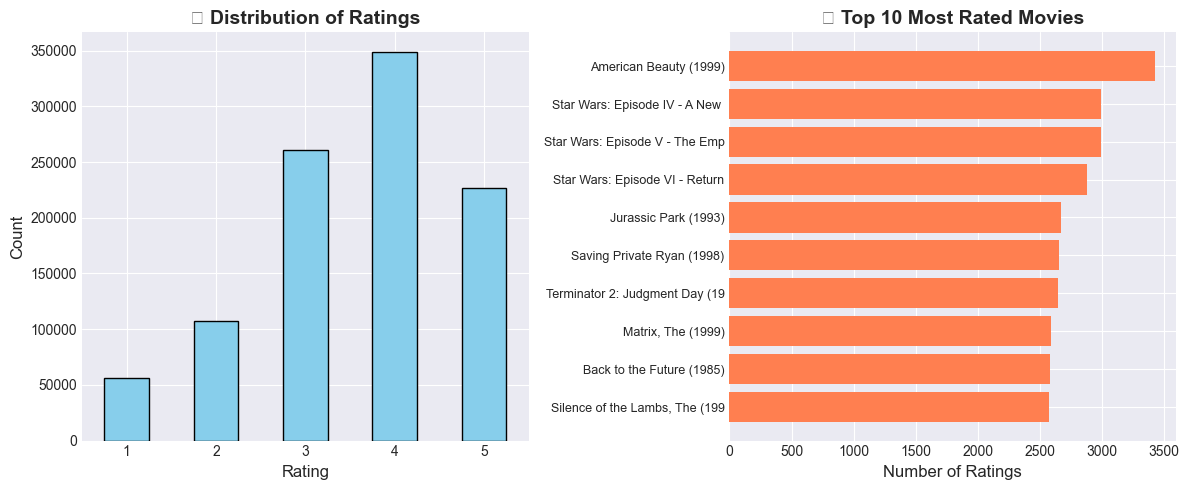


⭐ Average Rating: 3.58


In [5]:
plt.figure(figsize=(12, 5))

# Rating distribution
plt.subplot(1, 2, 1)
ratings['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('📊 Distribution of Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Top 10 most rated movies
plt.subplot(1, 2, 2)
top_movies = ratings['movie_id'].value_counts().head(10)
movie_titles = [movies[movies['movie_id']==mid]['title'].values[0] for mid in top_movies.index]
plt.barh(range(10), top_movies.values, color='coral')
plt.yticks(range(10), [title[:30] for title in movie_titles], fontsize=9)
plt.xlabel('Number of Ratings', fontsize=12)
plt.title('🎬 Top 10 Most Rated Movies', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n⭐ Average Rating: {ratings['rating'].mean():.2f}")

---
## 🧩 Step 5: Create User-Item Matrix

This is the **most important step**!

We create a matrix where:
- **Rows** = Users
- **Columns** = Movies
- **Values** = Ratings

Most cells will be empty (NaN) because users haven't rated all movies.

In [6]:
# Create user-item matrix using pivot
print("🔨 Creating User-Item Matrix...")

user_item_matrix = ratings.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
)

print(f"✅ Matrix created!")
print(f"\n📐 Matrix Shape: {user_item_matrix.shape}")
print(f"   ({user_item_matrix.shape[0]} users × {user_item_matrix.shape[1]} movies)")

# Display a small sample
print("\n📌 Sample of User-Item Matrix (first 5 users, first 5 movies):")
print(user_item_matrix.iloc[:5, :5])

🔨 Creating User-Item Matrix...
✅ Matrix created!

📐 Matrix Shape: (6040, 3706)
   (6040 users × 3706 movies)

📌 Sample of User-Item Matrix (first 5 users, first 5 movies):
movie_id    1   2   3   4   5
user_id                      
1         5.0 NaN NaN NaN NaN
2         NaN NaN NaN NaN NaN
3         NaN NaN NaN NaN NaN
4         NaN NaN NaN NaN NaN
5         NaN NaN NaN NaN NaN


---
## 🎯 Step 6: Prepare Data for SVD

SVD can't handle missing values (NaN), so we:
1. Fill NaN with 0 (means "not rated")
2. Normalize by subtracting user's mean rating

In [7]:
# Fill NaN with 0
user_item_matrix_filled = user_item_matrix.fillna(0)

# Calculate mean rating for each user (excluding 0s)
user_ratings_mean = user_item_matrix.mean(axis=1)

# Normalize by subtracting user mean
user_item_matrix_normalized = user_item_matrix_filled.sub(user_ratings_mean, axis=0)

print("✅ Data normalized!")
print(f"\n📊 Normalized matrix shape: {user_item_matrix_normalized.shape}")
print("\n💡 Why normalize? To account for users who rate harshly vs. generously!")

✅ Data normalized!

📊 Normalized matrix shape: (6040, 3706)

💡 Why normalize? To account for users who rate harshly vs. generously!


---
## 🔮 Step 7: Apply SVD (The Magic! ✨)

### What SVD Does:
SVD breaks our matrix into 3 parts:
```
R = U × Σ × V^T
```

- **U** = User features (hidden patterns about user preferences)
- **Σ** = Singular values (importance of each pattern)
- **V^T** = Movie features (hidden patterns about movie characteristics)

We use **k=50** latent factors (hidden patterns).

In [8]:
print("🔮 Applying SVD decomposition...\n")

# Number of latent factors (hidden patterns)
k = 50

# Perform SVD
U, sigma, Vt = svds(user_item_matrix_normalized.values, k=k)

# Convert sigma to diagonal matrix
sigma = np.diag(sigma)

print("✅ SVD completed!")
print(f"\n📐 Matrix Shapes:")
print(f"   U (User features):  {U.shape}")
print(f"   Σ (Singular values): {sigma.shape}")
print(f"   V^T (Movie features): {Vt.shape}")

print(f"\n💡 We've reduced {user_item_matrix.shape[1]} movies to {k} hidden patterns!")

🔮 Applying SVD decomposition...

✅ SVD completed!

📐 Matrix Shapes:
   U (User features):  (6040, 50)
   Σ (Singular values): (50, 50)
   V^T (Movie features): (50, 3706)

💡 We've reduced 3706 movies to 50 hidden patterns!


---
## 🎬 Step 8: Reconstruct & Predict Ratings

Now we multiply U × Σ × V^T back together to get **predicted ratings**!

In [9]:
# Reconstruct the matrix
predicted_ratings_normalized = np.dot(np.dot(U, sigma), Vt)

# Add back the user means
predicted_ratings = predicted_ratings_normalized + user_ratings_mean.values.reshape(-1, 1)

# Convert to DataFrame
predicted_ratings_df = pd.DataFrame(
    predicted_ratings,
    columns=user_item_matrix.columns,
    index=user_item_matrix.index
)

print("✅ Predicted ratings matrix created!")
print(f"\n📊 Shape: {predicted_ratings_df.shape}")
print("\n📌 Sample predictions (first 5 users, first 5 movies):")
print(predicted_ratings_df.iloc[:5, :5].round(2))

✅ Predicted ratings matrix created!

📊 Shape: (6040, 3706)

📌 Sample predictions (first 5 users, first 5 movies):
movie_id     1     2     3     4     5
user_id                               
1         4.14  0.18 -0.23 -0.05  0.04
2         0.77  0.16  0.34  0.01  0.02
3         1.93  0.41  0.10 -0.02 -0.05
4         0.28 -0.05  0.01  0.07  0.05
5         1.42  0.06 -0.07  0.23 -0.02


---
## 🎯 Step 9: Build Recommendation Function

This function recommends movies for a given user!

In [10]:
def recommend_movies(user_id, num_recommendations=10):
    """
    Recommend movies for a specific user
    
    Parameters:
    - user_id: The user ID to get recommendations for
    - num_recommendations: Number of movies to recommend
    
    Returns:
    - DataFrame with recommended movies and predicted ratings
    """
    
    # Check if user exists
    if user_id not in predicted_ratings_df.index:
        return f"❌ User {user_id} not found in dataset!"
    
    # Get user's predicted ratings
    user_predictions = predicted_ratings_df.loc[user_id]
    
    # Get movies user has already rated
    user_rated = user_item_matrix.loc[user_id]
    user_rated_movies = user_rated[user_rated.notna()].index
    
    # Filter out already rated movies
    recommendations = user_predictions.drop(user_rated_movies)
    
    # Sort by predicted rating (descending)
    recommendations = recommendations.sort_values(ascending=False)
    
    # Get top N recommendations
    top_recommendations = recommendations.head(num_recommendations)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'movie_id': top_recommendations.index,
        'predicted_rating': top_recommendations.values
    })
    
    # Merge with movie titles
    results = results.merge(movies, on='movie_id', how='left')
    
    return results[['movie_id', 'title', 'genre', 'predicted_rating']]

print("✅ Recommendation function created!")

✅ Recommendation function created!


---
## 🎮 Step 10: Interactive Recommendation System

Let's test our recommendation system with an example user!

In [11]:
# Example: Get recommendations for User ID 1
test_user_id = 1

print(f"🎬 MOVIE RECOMMENDATIONS FOR USER {test_user_id}")
print("="*80)

# Show what user has rated before
user_past_ratings = ratings[ratings['user_id'] == test_user_id].merge(movies, on='movie_id')
print(f"\n📌 USER'S PAST RATINGS (showing 10):")
print(user_past_ratings[['title', 'rating', 'genre']].head(10).to_string(index=False))

# Get recommendations
recommendations = recommend_movies(test_user_id, num_recommendations=10)

print(f"\n\n🌟 TOP 10 RECOMMENDED MOVIES:")
print("="*80)

for idx, row in recommendations.iterrows():
    print(f"{idx+1}. {row['title']}")
    print(f"   Genre: {row['genre']}")
    print(f"   Predicted Rating: ⭐ {row['predicted_rating']:.2f}/5.00")
    print()

🎬 MOVIE RECOMMENDATIONS FOR USER 1

📌 USER'S PAST RATINGS (showing 10):
                                 title  rating                              genre
One Flew Over the Cuckoo's Nest (1975)       5                              Drama
      James and the Giant Peach (1996)       3       Animation|Children's|Musical
                   My Fair Lady (1964)       3                    Musical|Romance
                Erin Brockovich (2000)       4                              Drama
                  Bug's Life, A (1998)       5        Animation|Children's|Comedy
            Princess Bride, The (1987)       3    Action|Adventure|Comedy|Romance
                        Ben-Hur (1959)       5             Action|Adventure|Drama
             Christmas Story, A (1983)       5                       Comedy|Drama
Snow White and the Seven Dwarfs (1937)       4       Animation|Children's|Musical
              Wizard of Oz, The (1939)       4 Adventure|Children's|Drama|Musical


🌟 TOP 10 RECOMMENDED MOV

---
## 🧪 Step 11: Try Different Users!

**Your Turn!** Change the user_id below to get recommendations for different users:

In [12]:
# 🎯 CHANGE THIS VALUE TO TEST DIFFERENT USERS!
user_id = 25  # Try: 1, 25, 50, 100, etc.

print(f"🎬 TOP 10 MOVIE RECOMMENDATIONS FOR USER {user_id}:")
print("="*80)

recommendations = recommend_movies(user_id, num_recommendations=10)

if isinstance(recommendations, str):
    print(recommendations)
else:
    for idx, row in recommendations.iterrows():
        print(f"{idx+1}. {row['title']}")
        print(f"   📁 Genre: {row['genre']}")
        print(f"   ⭐ Predicted Rating: {row['predicted_rating']:.2f}")
        print()

🎬 TOP 10 MOVIE RECOMMENDATIONS FOR USER 25:
1. Terminator 2: Judgment Day (1991)
   📁 Genre: Action|Sci-Fi|Thriller
   ⭐ Predicted Rating: 2.36

2. Stargate (1994)
   📁 Genre: Action|Adventure|Sci-Fi
   ⭐ Predicted Rating: 2.32

3. Princess Bride, The (1987)
   📁 Genre: Action|Adventure|Comedy|Romance
   ⭐ Predicted Rating: 2.25

4. Fifth Element, The (1997)
   📁 Genre: Action|Sci-Fi
   ⭐ Predicted Rating: 2.12

5. Total Recall (1990)
   📁 Genre: Action|Adventure|Sci-Fi|Thriller
   ⭐ Predicted Rating: 2.12

6. Contact (1997)
   📁 Genre: Drama|Sci-Fi
   ⭐ Predicted Rating: 2.09

7. Sixth Sense, The (1999)
   📁 Genre: Thriller
   ⭐ Predicted Rating: 1.90

8. Mission: Impossible (1996)
   📁 Genre: Action|Adventure|Mystery
   ⭐ Predicted Rating: 1.71

9. Abyss, The (1989)
   📁 Genre: Action|Adventure|Sci-Fi|Thriller
   ⭐ Predicted Rating: 1.60

10. American Pie (1999)
   📁 Genre: Comedy
   ⭐ Predicted Rating: 1.52



---
## 📊 Step 12: Evaluate Model Performance

Let's compare actual vs. predicted ratings!

In [13]:
# Sample 1000 actual ratings to compare
sample_size = 1000
sample_ratings = ratings.sample(n=sample_size, random_state=42)

actual = []
predicted = []

for _, row in sample_ratings.iterrows():
    user = row['user_id']
    movie = row['movie_id']
    
    if user in predicted_ratings_df.index and movie in predicted_ratings_df.columns:
        actual.append(row['rating'])
        predicted.append(predicted_ratings_df.loc[user, movie])

# Calculate RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"📊 MODEL PERFORMANCE:")
print("="*50)
print(f"✅ RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"✅ MAE (Mean Absolute Error): {mae:.4f}")
print(f"\n💡 Lower values = Better predictions!")
print(f"💡 On average, predictions are off by ~{mae:.2f} stars")

📊 MODEL PERFORMANCE:
✅ RMSE (Root Mean Squared Error): 2.1719
✅ MAE (Mean Absolute Error): 1.8627

💡 Lower values = Better predictions!
💡 On average, predictions are off by ~1.86 stars


---
## 📈 Step 13: Visualize Predictions vs Actual

Let's see how well our model performs!

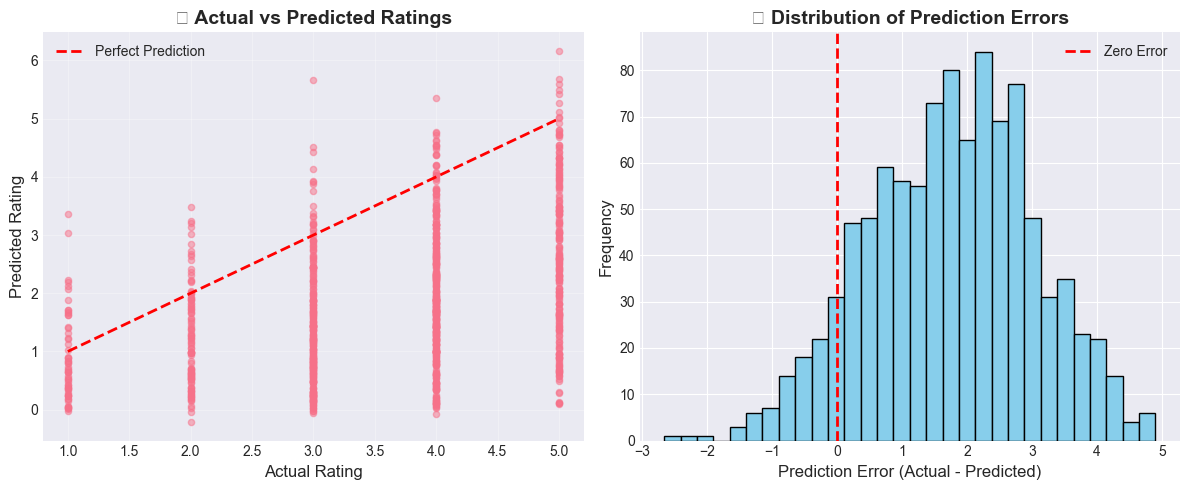


💡 Ideally, points should be close to the red diagonal line!
💡 Errors centered around 0 indicate unbiased predictions!


In [14]:
plt.figure(figsize=(12, 5))

# Scatter plot: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(actual, predicted, alpha=0.5, s=20)
plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Rating', fontsize=12)
plt.ylabel('Predicted Rating', fontsize=12)
plt.title('📊 Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 2, 2)
errors = np.array(actual) - np.array(predicted)
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('📊 Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n💡 Ideally, points should be close to the red diagonal line!")
print(f"💡 Errors centered around 0 indicate unbiased predictions!")

---
## 🎓 Summary: What We Learned!

### ✅ Congratulations! You've built a Movie Recommendation System using SVD!

Here's what we did:

1. **Loaded Data** - Ratings and movie information
2. **Created User-Item Matrix** - Organized ratings in a grid format
3. **Applied SVD** - Decomposed the matrix into U, Σ, and V^T
4. **Made Predictions** - Reconstructed the matrix to predict missing ratings
5. **Built Recommendations** - Created a function to suggest movies
6. **Evaluated Performance** - Measured prediction accuracy

### 🧠 Key Concepts:

- **Collaborative Filtering**: Recommending based on similar users' preferences
- **SVD**: Matrix factorization technique to find hidden patterns
- **Latent Factors**: Hidden features (e.g., "action lover", "comedy fan")
- **Matrix Completion**: Filling in missing ratings

### 🚀 Next Steps:

- Try different values of k (number of latent factors)
- Experiment with different users
- Add genre-based filtering
- Build a web interface using Streamlit!

---

## 🎉 You're now a Recommendation Systems expert! Keep learning! 🎉